## **Data Load**

In [9]:
from memory_profiler import memory_usage

def calculate_squares():
    data = [i ** 2 for i in range(1000000)]
    del data  # Clear memory after usage

memory_usage(calculate_squares)

[210.9140625, 206.73046875, 207.90234375, 211.30859375, 215.58984375]

In [6]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import timeit
import tracemalloc

In [59]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


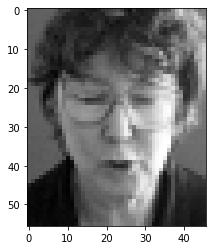

In [40]:
# show one example image
plt.imshow(np.reshape(x_train[:,0],(46,56)).T, cmap = 'gist_gray')

## **Q5. RF classifier**

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# x_train, y_train, x_test, y_test, n_estimators=100, max_depth='1000', bootstrap=True, random_state=0, max_samples=0.8, max_features="sqrt", criterion='entropy'
# max_sample -> 0~1.0
# max_feartures -> None, sqrt, log2
# criterion -> entropy, gini, log_loss

def RF_classification(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=1000, bootstrap=True, random_state=0, max_samples=0.8, max_features="sqrt", criterion='entropy', time_memory_check=False):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
    if time_memory_check:
        tracemalloc.start() 
        start_time = timeit.default_timer() 
        
        rf_clf.fit(x_train.T, y_train.ravel())
        
        current, train_peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        end_time = timeit.default_timer()

        train_time = end_time - start_time
        # print(f"Current memory usage: {current / 10**6} MB")
        print(f"Training Memory Usage (Peak): {train_peak / 10**6} MB")
        print(f"Training Execution Time: {train_time:.8f} seconds")
        print('\n')

    else:
        rf_clf.fit(x_train.T, y_train.ravel())
    
    if time_memory_check:
        tracemalloc.start() 
        start_time = timeit.default_timer()

        y_pred = rf_clf.predict(x_test.T)

        current, test_peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        end_time = timeit.default_timer()

        test_time = end_time - start_time

        # print(f"Current memory usage: {current / 10**6} MB")
        print(f"Test Memory Usage (Peak): {test_peak / 10**6} MB")
        print(f"Test Execution Time: {test_time:.8f} seconds")
        print('\n')

    else:
        y_pred = rf_clf.predict(x_test.T)

    accuracy = accuracy_score(y_test.T, y_pred)

    # Full classification report
    # print(classification_report(y_test.T, y_pred, zero_division=0))

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)
    print(f"Maximum depth of trees in the forest: {max_tree_depth}")

    return accuracy

accuracy = RF_classification(x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)
print(f"Accuracy: {accuracy * 100:.2f}%")

Training Memory Usage (Peak): 4.419674 MB
Training Execution Time: 0.18192417 seconds


Test Memory Usage (Peak): 1.210583 MB
Test Execution Time: 0.00319358 seconds


Maximum depth of trees in the forest: 9
Accuracy: 33.65%


In [30]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

def RF_random_search():
    rf_clf = RandomForestClassifier()
    
    param_distributions = dict()
    param_distributions['n_estimators'] = [10, 20, 30, 40, 50]
    param_distributions['max_depth'] = [1,2,3,4,5]
    param_distributions['max_samples'] = [0.1, 0.2, 0.3, 1]
    param_distributions['max_features'] = ["sqrt", "log2"]
    param_distributions['criterion'] = ["gini", "entropy", "log_loss"]
    
    random_search = RandomizedSearchCV(rf_clf, param_distributions, n_iter=10, scoring='accuracy', cv=5, random_state=None)
    random_result = random_search.fit(x_train.T, y_train.ravel())

    print(f'Best Parameters: {random_search.best_params_}')
    print(f'Best Accuracy: {random_result.best_score_}')

    best_rf = random_search.best_estimator_

    y_pred = best_rf.predict(x_test.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return random_search.best_estimator_

best_rf = RF_random_search()

Best Parameters: {'n_estimators': 40, 'max_samples': 0.3, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy'}
Best Accuracy: 0.3822432587492829
Accuracy: 50.00%


Two-Pixel Test

In [33]:
# create two-pixel test
import random
def create_two_pixel_features(X, n_pairs=None, random_seed=None):
    n_samples, n_features = X.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((n_samples, len(feature_pairs)))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[:, idx] = X[:, i] - X[:, j]

    return new_features

In [46]:
x_combined = np.concatenate([x_train, x_test], axis=1)
x_combined_2pix = create_two_pixel_features(x_combined.T, n_pairs=2576, random_seed=i).T

x_train_2pix = x_combined_2pix[:, :x_train.shape[1]]
x_test_2pix = x_combined_2pix[:, x_train.shape[1]:]

accuracy = RF_classification(x_train_2pix, y_train, x_test_2pix, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)
print(accuracy)

Training Memory Usage (Peak): 4.419131 MB
Training Execution Time: 0.17051700 seconds


Test Memory Usage (Peak): 1.210631 MB
Test Execution Time: 0.00327413 seconds


Maximum depth of trees in the forest: 10
0.25


In [37]:
# average result of two-pixel test
num_iter = 30

def avg_acc(num_iter):
    acc_sum = 0
    for i in range(num_iter):
        x_combined = np.concatenate([x_train, x_test], axis=1)
        x_combined_2pix = create_two_pixel_features(x_combined.T, n_pairs=2576, random_seed=i).T

        x_train_2pix = x_combined_2pix[:, :x_train.shape[1]]
        x_test_2pix = x_combined_2pix[:, x_train.shape[1]:]

        acc_sum += RF_classification(x_train_2pix, y_train, x_test_2pix, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy')

    return acc_sum / num_iter

accuracy = avg_acc(num_iter)
print(f"Average Accuracy: {accuracy * 100:.2f}%")

Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 11
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 10
Maximum depth of trees in the forest: 10
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 10
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 10
Maximum depth of trees in the forest: 9
Maximum depth of trees in the forest: 10
Maximum depth of trees in the forest: 9
Maximum depth of trees in the fore